In [1]:
import os
print(os.listdir("../input/"))

['testData.tsv', 'sampleSubmission.csv', 'labeledTrainData.tsv', 'unlabeledTrainData.tsv']


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd


train = pd.read_csv("../input/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("../input/testData.tsv", header=0, delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv('../input/unlabeledTrainData.tsv', 
                              header=0, delimiter='\t', quoting=3)

print(train.shape)
print(test.shape)
print(unlabeled_train.shape)

print(train['review'].size)
print(test['review'].size)
print(unlabeled_train['review'].size)

(25000, 3)
(25000, 2)
(50000, 2)
25000
25000
50000


In [3]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [65]:
import re
import nltk

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from multiprocessing import Pool

class KaggleWord2VecUtility(object):

    @staticmethod
    def review_to_wordlist(review, remove_stopwords=False):
        # 1. HTML 제거
        review_text = BeautifulSoup(review, "html.parser").get_text()
        # 2. 특수문자를 공백으로 바꿔줌
        review_text = re.sub('[^a-zA-Z]', ' ', review_text)
        # 3. 소문자로 변환 후 나눈다.
        words = review_text.lower().split()
        # 4. 불용어 제거
        if remove_stopwords:
            stops = set(stopwords.words('english'))
            words = [w for w in words if not w in stops]
        # 5. 어간추출
        stemmer = SnowballStemmer('english')
        words = [stemmer.stem(w) for w in words]
        # 6. 리스트 형태로 반환
        return(words)

    @staticmethod
    def review_to_join_words( review, remove_stopwords=False ):
        words = KaggleWord2VecUtility.review_to_wordlist(\
            review, remove_stopwords=False)
        join_words = ' '.join(words)
        return join_words

    @staticmethod
    def review_to_sentences( review, remove_stopwords=False ):
        # punkt tokenizer를 로드한다.
        """
        이 때, pickle을 사용하는데
        pickle을 통해 값을 저장하면 원래 변수에 연결 된 참조값 역시 저장된다.
        저장된 pickle을 다시 읽으면 변수에 연결되었던
        모든 레퍼런스가 계속 참조 상태를 유지한다.
        """
        tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        # 1. nltk tokenizer를 사용해서 단어로 토큰화 하고 공백 등을 제거한다.
        raw_sentences = tokenizer.tokenize(review.strip())
        # 2. 각 문장을 순회한다.
        sentences = []
        for raw_sentence in raw_sentences:
            # 비어있다면 skip
            if len(raw_sentence) > 0:
                # 태그제거, 알파벳문자가 아닌 것은 공백으로 치환, 불용어제거
                sentences.append(\
                    KaggleWord2VecUtility.review_to_wordlist(\
                    raw_sentence, remove_stopwords))
        return sentences


    # 참고 : https://gist.github.com/yong27/7869662
    # http://www.racketracer.com/2016/07/06/pandas-in-parallel/
    # 속도 개선을 위해 멀티 스레드로 작업하도록
    @staticmethod
    def _apply_df(args):
        df, func, kwargs = args
        return df.apply(func, **kwargs)

    @staticmethod
    def apply_by_multiprocessing(df, func, **kwargs):
        # 키워드 항목 중 workers 파라메터를 꺼냄
        workers = kwargs.pop('workers')
        # 위에서 가져온 workers 수로 프로세스 풀을 정의
        pool = Pool(processes=workers)
        # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
        result = pool.map(KaggleWord2VecUtility._apply_df, [(d, func, kwargs)
                for d in np.array_split(df, workers)])
        pool.close()
        # 작업 결과를 합쳐서 반환
        return pd.concat(result)

In [18]:
KaggleWord2VecUtility.review_to_wordlist(train['review'][0])[:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [19]:
sentences = []
for review in train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(review, remove_stopwords=False)

In [20]:
for review in unlabeled_train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(
        review, remove_stopwords=False)

In [21]:
len(sentences)

795538

In [22]:
sentences[0][:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [23]:
sentences[1][:10]

['mayb', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into']

In [24]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [25]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도 수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

2019-05-27 08:12:39,755 : INFO : 'pattern' package not found; tag filters are not available for English
2019-05-27 08:12:39,765 : INFO : collecting all words and their counts
2019-05-27 08:12:39,766 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-05-27 08:12:39,828 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 12465 word types
2019-05-27 08:12:39,895 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 17070 word types
2019-05-27 08:12:39,960 : INFO : PROGRESS: at sentence #30000, processed 671314 words, keeping 20370 word types
2019-05-27 08:12:40,032 : INFO : PROGRESS: at sentence #40000, processed 897814 words, keeping 23125 word types
2019-05-27 08:12:40,101 : INFO : PROGRESS: at sentence #50000, processed 1116962 words, keeping 25365 word types
2019-05-27 08:12:40,169 : INFO : PROGRESS: at sentence #60000, processed 1338403 words, keeping 27283 word types
2019-05-27 08:12:40,240 : INFO : PROGRESS: at senten

2019-05-27 08:12:45,018 : INFO : PROGRESS: at sentence #710000, processed 15880371 words, keeping 82560 word types
2019-05-27 08:12:45,094 : INFO : PROGRESS: at sentence #720000, processed 16105658 words, keeping 83036 word types
2019-05-27 08:12:45,169 : INFO : PROGRESS: at sentence #730000, processed 16332039 words, keeping 83571 word types
2019-05-27 08:12:45,245 : INFO : PROGRESS: at sentence #740000, processed 16553072 words, keeping 84127 word types
2019-05-27 08:12:45,317 : INFO : PROGRESS: at sentence #750000, processed 16771399 words, keeping 84599 word types
2019-05-27 08:12:45,390 : INFO : PROGRESS: at sentence #760000, processed 16990803 words, keeping 85068 word types
2019-05-27 08:12:45,467 : INFO : PROGRESS: at sentence #770000, processed 17217940 words, keeping 85644 word types
2019-05-27 08:12:45,543 : INFO : PROGRESS: at sentence #780000, processed 17448086 words, keeping 86160 word types
2019-05-27 08:12:45,621 : INFO : PROGRESS: at sentence #790000, processed 176751

2019-05-27 08:13:34,527 : INFO : EPOCH 3 - PROGRESS: at 28.82% examples, 611165 words/s, in_qsize 7, out_qsize 0
2019-05-27 08:13:35,532 : INFO : EPOCH 3 - PROGRESS: at 33.77% examples, 613054 words/s, in_qsize 7, out_qsize 0
2019-05-27 08:13:36,539 : INFO : EPOCH 3 - PROGRESS: at 38.57% examples, 613436 words/s, in_qsize 7, out_qsize 0
2019-05-27 08:13:37,550 : INFO : EPOCH 3 - PROGRESS: at 43.46% examples, 615152 words/s, in_qsize 7, out_qsize 0
2019-05-27 08:13:38,559 : INFO : EPOCH 3 - PROGRESS: at 48.27% examples, 615119 words/s, in_qsize 7, out_qsize 0
2019-05-27 08:13:39,561 : INFO : EPOCH 3 - PROGRESS: at 53.10% examples, 615571 words/s, in_qsize 7, out_qsize 0
2019-05-27 08:13:40,564 : INFO : EPOCH 3 - PROGRESS: at 57.84% examples, 615838 words/s, in_qsize 7, out_qsize 0
2019-05-27 08:13:41,578 : INFO : EPOCH 3 - PROGRESS: at 62.60% examples, 615078 words/s, in_qsize 8, out_qsize 1
2019-05-27 08:13:42,585 : INFO : EPOCH 3 - PROGRESS: at 67.34% examples, 614666 words/s, in_qsiz

In [26]:
# 학습이 완료 되면 필요없는 메모리를 unload 시킨다.
model.init_sims(replace=True)

model_name = '300features_40minwords_10text'
# model_name = '300features_50minwords_20text'
model.save(model_name)

2019-05-27 08:14:32,057 : INFO : precomputing L2-norms of word weight vectors
2019-05-27 08:14:32,077 : INFO : saving Word2Vec object under 300features_40minwords_10text, separately None
2019-05-27 08:14:32,078 : INFO : not storing attribute vectors_norm
2019-05-27 08:14:32,080 : INFO : not storing attribute cum_table
2019-05-27 08:14:32,081 : WARNING : this function is deprecated, use smart_open.open instead
2019-05-27 08:14:32,475 : INFO : saved 300features_40minwords_10text


# Exploring the Model Results

In [27]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('man woman child kitchen'.split())

'kitchen'

In [28]:
model.wv.doesnt_match("france england germany berlin".split())

2019-05-27 08:18:19,588 : WARNING : vectors for words {'germany', 'france'} are not present in the model, ignoring these words


'berlin'

In [29]:
# 가장 유사한 단어를 추출
model.wv.most_similar("man")

[('woman', 0.6420029401779175),
 ('millionair', 0.5091785192489624),
 ('lad', 0.5046861171722412),
 ('ladi', 0.4894580841064453),
 ('businessman', 0.4794045090675354),
 ('farmer', 0.4669918119907379),
 ('men', 0.4654066264629364),
 ('priest', 0.46315798163414),
 ('widow', 0.45933783054351807),
 ('doctor', 0.45412319898605347)]

In [30]:
model.wv.most_similar("queen")

[('princess', 0.6187180876731873),
 ('mistress', 0.5801680088043213),
 ('victoria', 0.5768566131591797),
 ('latifah', 0.5602644681930542),
 ('madam', 0.5599470138549805),
 ('eva', 0.5582484006881714),
 ('starlet', 0.5467177629470825),
 ('maid', 0.535918116569519),
 ('duchess', 0.5342199802398682),
 ('regina', 0.5334360003471375)]

In [31]:
model.wv.most_similar("film")

[('movi', 0.857789158821106),
 ('flick', 0.6206938028335571),
 ('documentari', 0.5748720765113831),
 ('pictur', 0.5426288843154907),
 ('cinema', 0.5122599005699158),
 ('it', 0.4992506206035614),
 ('genr', 0.483175665140152),
 ('sequel', 0.48181113600730896),
 ('masterpiec', 0.481436550617218),
 ('effort', 0.47286707162857056)]

In [32]:
# model.wv.most_similar("happy")
model.wv.most_similar("happi") # stemming 처리 시

[('unhappi', 0.4649035632610321),
 ('bitter', 0.4202926456928253),
 ('sad', 0.4147133231163025),
 ('satisfi', 0.3806600570678711),
 ('afraid', 0.3791179060935974),
 ('comfort', 0.3698452413082123),
 ('glad', 0.36544930934906006),
 ('upset', 0.3574947118759155),
 ('lucki', 0.34888941049575806),
 ('joy', 0.34632566571235657)]

# T-SNE

In [33]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

2019-05-27 08:19:24,570 : INFO : loading Doc2Vec object from 300features_40minwords_10text
2019-05-27 08:19:24,571 : WARNING : this function is deprecated, use smart_open.open instead
2019-05-27 08:19:24,900 : INFO : loading wv recursively from 300features_40minwords_10text.wv.* with mmap=None
2019-05-27 08:19:24,902 : INFO : setting ignored attribute vectors_norm to None
2019-05-27 08:19:24,903 : INFO : loading vocabulary recursively from 300features_40minwords_10text.vocabulary.* with mmap=None
2019-05-27 08:19:24,904 : INFO : loading trainables recursively from 300features_40minwords_10text.trainables.* with mmap=None
2019-05-27 08:19:24,904 : INFO : setting ignored attribute cum_table to None
2019-05-27 08:19:24,905 : INFO : loaded 300features_40minwords_10text


11986
[ 0.12335844  0.13191052  0.01962896 -0.00856141 -0.02209314 -0.00358412
 -0.00967849 -0.14973272 -0.07954669 -0.03450857]


In [34]:

df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [35]:
df.head(10)

,x,y
with,64.205101,5.823351
all,-19.568016,52.353298
this,-13.811775,20.165369
stuff,20.172018,-7.418868
go,-16.418568,-20.276791
down,85.634506,32.448624
at,80.231979,7.600593
the,-0.952867,56.189754
moment,-50.095146,57.419304
mj,-2.516365,-75.790291


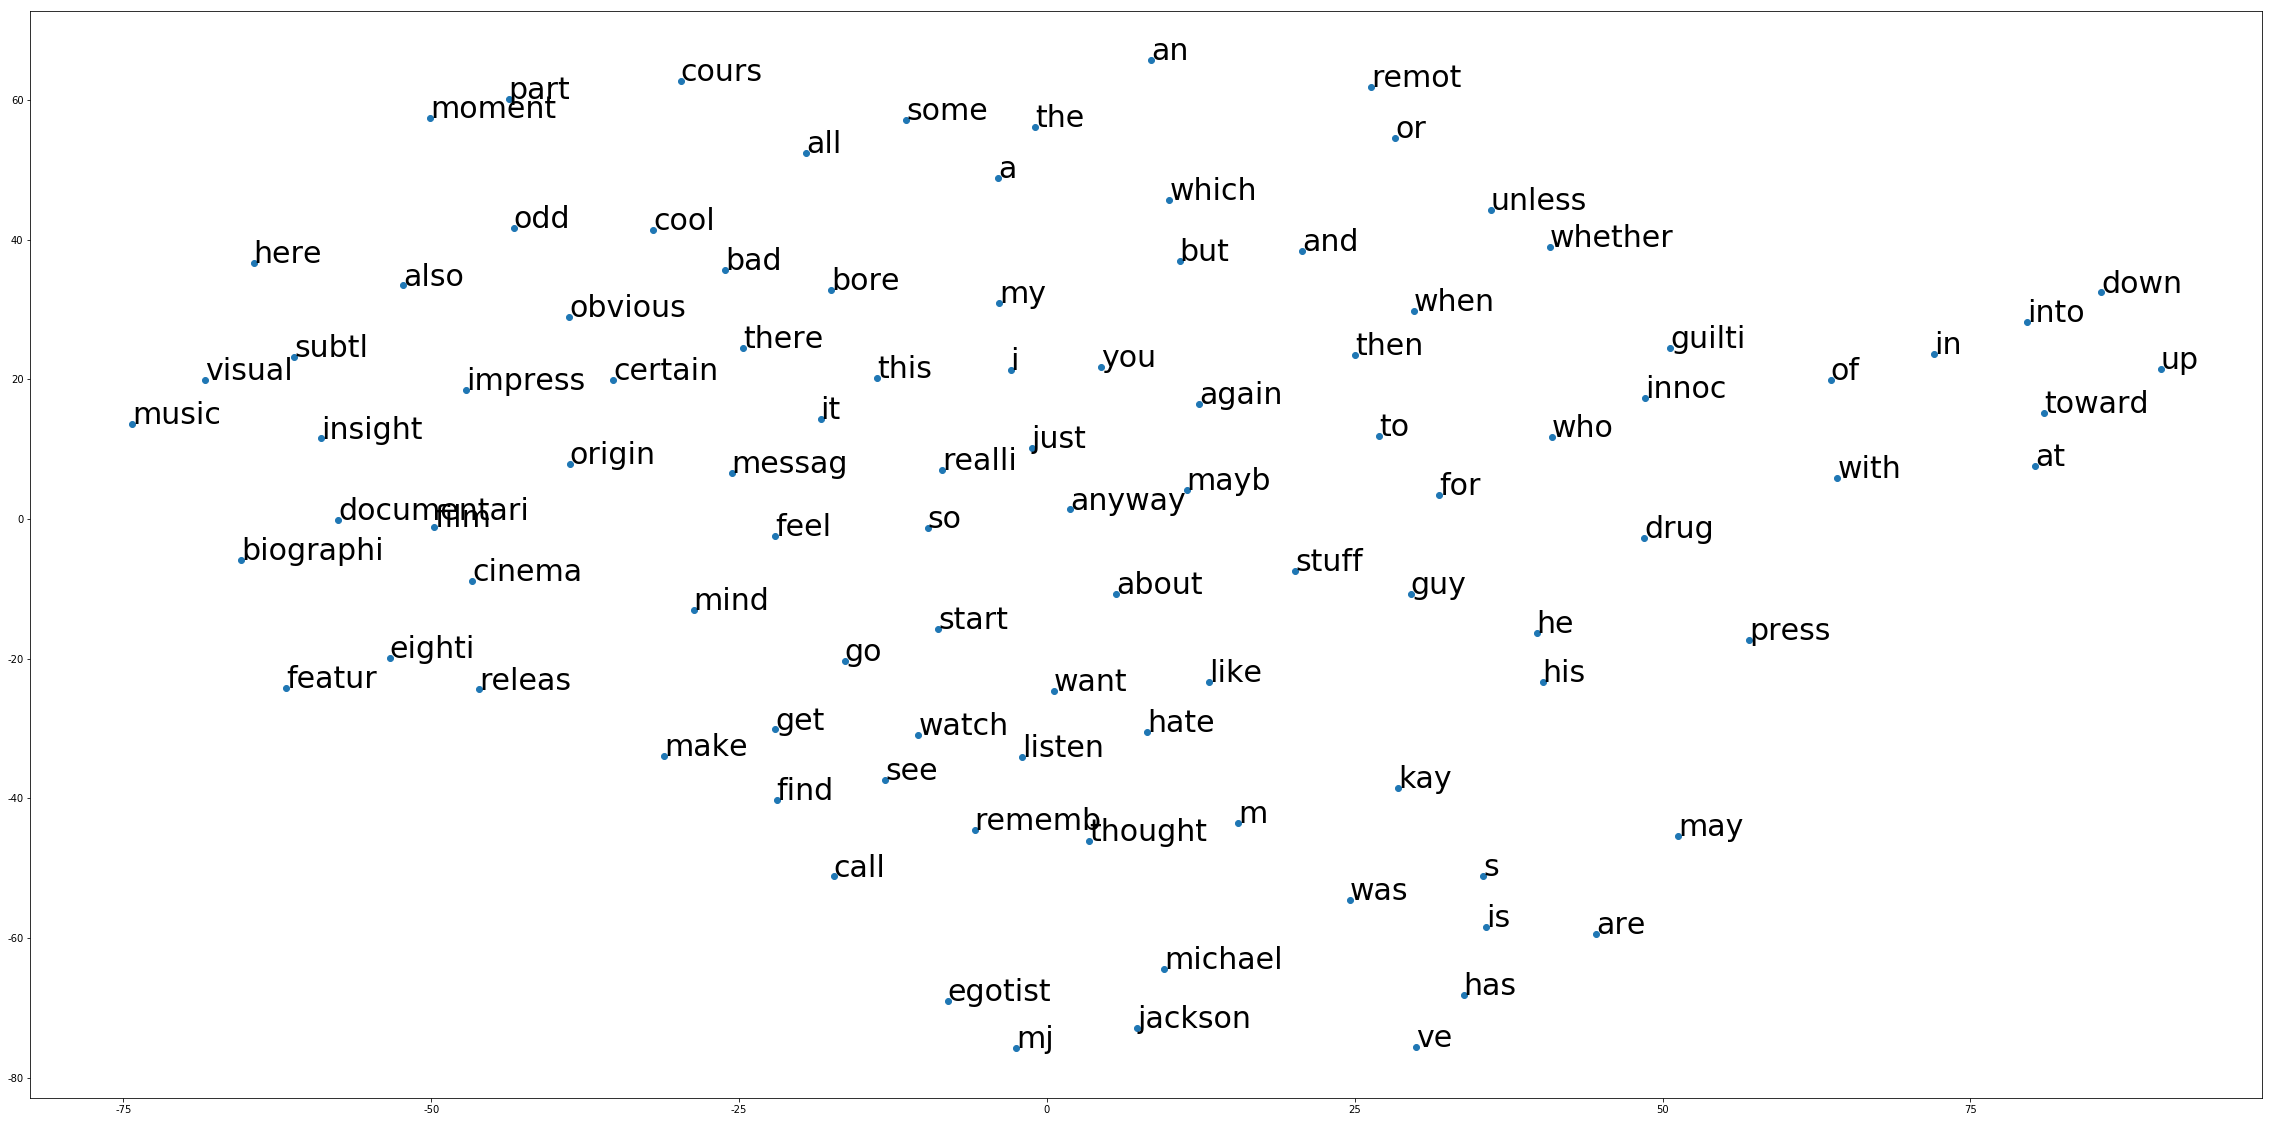

In [36]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

In [38]:
import numpy as np

def makeFeatureVec(words, model, num_features):
    """
    주어진 문장에서 단어 벡터의 평균을 구하는 함수
    """
    # 속도를 위해 0으로 채운 배열로 초기화 한다.
    featureVec = np.zeros((num_features,),dtype="float32")

    nwords = 0.
    # Index2word는 모델의 사전에 있는 단어명을 담은 리스트이다.
    # 속도를 위해 set 형태로 초기화 한다.
    index2word_set = set(model.wv.index2word)
    # 루프를 돌며 모델 사전에 포함이 되는 단어라면 피처에 추가한다.
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 결과를 단어수로 나누어 평균을 구한다.
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [39]:
def getAvgFeatureVecs(reviews, model, num_features):
    # 리뷰 단어 목록의 각각에 대한 평균 feature 벡터를 계산하고 
    # 2D numpy 배열을 반환한다.
    
    # 카운터를 초기화 한다.
    counter = 0.
    # 속도를 위해 2D 넘파이 배열을 미리 할당한다.
    reviewFeatureVecs = np.zeros(
        (len(reviews),num_features),dtype="float32")
    
    for review in reviews:
       # 매 1000개 리뷰마다 상태를 출력
       if counter%1000. == 0.:
           print("Review %d of %d" % (counter, len(reviews)))
       # 평균 피처 벡터를 만들기 위해 위에서 정의한 함수를 호출한다.
       reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
       # 카운터를 증가시킨다.
       counter = counter + 1.
    return reviewFeatureVecs

In [40]:
# 멀티스레드로 4개의 워커를 사용해 처리한다.
def getCleanReviews(reviews):
    clean_reviews = []
    clean_reviews = KaggleWord2VecUtility.apply_by_multiprocessing(\
        reviews["review"], KaggleWord2VecUtility.review_to_wordlist,\
        workers=4)
    return clean_reviews

In [41]:
%time trainDataVecs = getAvgFeatureVecs(\
    getCleanReviews(train), model, num_features )

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 59.8 s, sys: 696 ms, total: 1min
Wall time: 1min 36s


In [42]:
%time testDataVecs = getAvgFeatureVecs(\
        getCleanReviews(test), model, num_features )

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 1min, sys: 892 ms, total: 1min 1s
Wall time: 1min 35s


In [43]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)

In [44]:
%time forest = forest.fit( trainDataVecs, train["sentiment"] )

CPU times: user 1min 3s, sys: 52 ms, total: 1min 3s
Wall time: 16.3 s


In [45]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, trainDataVecs, \
    train['sentiment'], cv=10, scoring='roc_auc'))

CPU times: user 5.24 s, sys: 1.05 s, total: 6.28 s
Wall time: 2min 31s


In [46]:
score

0.9019035839999999

In [47]:
result = forest.predict( testDataVecs )

In [48]:
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv('Word2Vec_AverageVectors_{0:.5f}.csv'.format(score), 
              index=False, quoting=3 )

In [49]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

138


0    12569
1    12431
Name: sentiment, dtype: int64

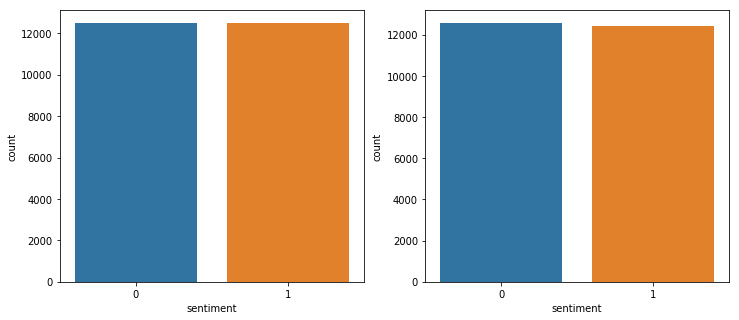

In [50]:
import seaborn as sns 
%matplotlib inline

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

# Clustering

In [52]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from bs4 import BeautifulSoup
import re
import time

from nltk.corpus import stopwords
import nltk.data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

model = Word2Vec.load('300features_40minwords_10text')
model

2019-05-27 08:51:54,283 : INFO : loading Word2Vec object from 300features_40minwords_10text
2019-05-27 08:51:54,284 : WARNING : this function is deprecated, use smart_open.open instead
2019-05-27 08:51:54,527 : INFO : loading wv recursively from 300features_40minwords_10text.wv.* with mmap=None
2019-05-27 08:51:54,529 : INFO : setting ignored attribute vectors_norm to None
2019-05-27 08:51:54,530 : INFO : loading vocabulary recursively from 300features_40minwords_10text.vocabulary.* with mmap=None
2019-05-27 08:51:54,531 : INFO : loading trainables recursively from 300features_40minwords_10text.trainables.* with mmap=None
2019-05-27 08:51:54,531 : INFO : setting ignored attribute cum_table to None
2019-05-27 08:51:54,532 : INFO : loaded 300features_40minwords_10text


In [53]:
# 숫자로 단어를 표현
# Word2Vec 모델은 어휘의 각 단어에 대한 feature 벡터로 구성되며 
# 'syn0'이라는 넘파이 배열로 저장된다.
# syn0의 행 수는 모델 어휘의 단어 수
# 컬럼 수는 2 부에서 설정 한 피처 벡터의 크기
type(model.wv.syn0)

numpy.ndarray

In [54]:
# syn0의 행 수는 모델 어휘의 단어 수
# 열 수는 2부에서 설정한 특징 벡터의 크기
model.wv.syn0.shape

(11986, 300)

In [55]:
# 개별 단어 벡터 접근
model.wv['flower'].shape

(300,)

In [56]:
model.wv['flower'][:10]

array([-0.02139016, -0.13117528,  0.02858955,  0.0689256 , -0.03649621,
       -0.10532678, -0.03565228, -0.00887936, -0.0211734 ,  0.05296646],
      dtype=float32)

In [57]:
# 단어 벡터에서 k-means를 실행하고 일부 클러스터를 찍어본다.
start = time.time() # 시작시간

# 클러스터의 크기 "k"를 어휘 크기의 1/5 이나 평균 5단어로 설정한다.
word_vectors = model.wv.syn0 # 어휘의 feature vector
num_clusters = word_vectors.shape[0] / 5
num_clusters = int(num_clusters)

# K means 를 정의하고 학습시킨다.
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# 끝난시간에서 시작시간을 빼서 걸린 시간을 구한다.
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

Time taken for K Means clustering:  347.6744978427887 seconds.


In [59]:
# 각 어휘 단어를 클러스터 번호에 매핑되게 word/Index 사전을 만든다.
idx = list(idx)
names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
#     word_centroid_map = dict(zip( model.wv.index2word, idx ))

# 첫번째 클러스터의 처음 10개를 출력
for cluster in range(0,10):
    # 클러스터 번호를 출력
    print("\nCluster {}".format(cluster))
    
    # 클러스터번호와 클러스터에 있는 단어를 찍는다.
    words = []
    for i in range(0,len(list(word_centroid_map.values()))):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['schtick']

Cluster 1
['disapprov', 'landlord', 'hubbi', 'stepfath', 'spank', 'instig', 'vindict']

Cluster 2
['vincent', 'marc', 'olivi', 'ronald', 'laurenc', 'colman', 'laughton', 'guin', 'grodin', 'coleman', 'terenc', 'rainer', 'fredric', 'cassel', 'freder', 'durn', 'boyer', 'incompar', 'fargo', 'novello', 'klaus', 'ledger', 'greenstreet', 'mcgraw', 'antoni']

Cluster 3
['templ', 'georgia', 'ranch', 'mississippi', 'plantat', 'moonlight', 'manor', 'eden', 'commune', 'malibu', 'holder', 'jerusalem', 'thumper', 'crust', 'salon']

Cluster 4
['lens']

Cluster 5
['bore', 'tire']

Cluster 6
['disc', 'disk', 'blurb']

Cluster 7
['peach', 'atop', 'waterfal', 'hobo', 'hut', 'derelict']

Cluster 8
['cruelti', 'inhuman', 'hunger', 'barbar']

Cluster 9
['cradl', 'fountain', 'surgic', 'boiler']


In [63]:
"""
판다스로 데이터프레임 형태의 데이터로 읽어온다.
QUOTE_MINIMAL (0), QUOTE_ALL (1), 
QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

그리고 이전 튜토리얼에서 했던 것처럼 clean_train_reviews 와 
clean_test_reviews 로 텍스트를 정제한다.
"""

train = pd.read_csv("../input/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("../input/testData.tsv", header=0, delimiter="\t", quoting=3)
# unlabeled_train = pd.read_csv( 'data/unlabeledTrainData.tsv', header=0,  delimiter="\t", quoting=3 )

In [66]:
# 학습 리뷰를 정제한다.
clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist( review, \
        remove_stopwords=True ))

In [67]:
# 테스트 리뷰를 정제한다.
clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist( review, \
        remove_stopwords=True ))

In [68]:
# bags of centroids 생성
# 속도를 위해 centroid 학습 세트 bag을 미리 할당 한다.
train_centroids = np.zeros((train["review"].size, num_clusters), \
    dtype="float32" )

train_centroids[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [69]:
# centroid 는 두 클러스터의 중심점을 정의 한 다음 중심점의 거리를 측정한 것
def create_bag_of_centroids( wordlist, word_centroid_map ):
    
    # 클러스터의 수는 word / centroid map에서 가장 높은 클러스트 인덱스와 같다.
    num_centroids = max( word_centroid_map.values() ) + 1
    
    # 속도를 위해 bag of centroids vector를 미리 할당한다.
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    
    # 루프를 돌며 단어가 word_centroid_map에 있다면
    # 해당되는 클러스터의 수를 하나씩 증가시켜 준다.
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    # bag of centroids를 반환한다.
    return bag_of_centroids

In [70]:
# 학습 리뷰를 bags of centroids 로 변환한다.
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

# 테스트 리뷰도 같은 방법으로 반복해 준다.
test_centroids = np.zeros(( test["review"].size, num_clusters), \
    dtype="float32" )

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1


# 랜덤포레스트를 사용하여 학습시키고 예측
forest = RandomForestClassifier(n_estimators = 100)

# train 데이터의 레이블을 통해 학습시키고 예측한다.
# 시간이 좀 소요되기 때문에 %time을 통해 걸린 시간을 찍도록 함
print("Fitting a random forest to labeled training data...")
%time forest = forest.fit(train_centroids, train["sentiment"])

Fitting a random forest to labeled training data...
CPU times: user 46.7 s, sys: 264 ms, total: 47 s
Wall time: 47 s


In [71]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, train_centroids, train['sentiment'], cv=10,\
    scoring='roc_auc'))

CPU times: user 6min 58s, sys: 1.87 s, total: 7min
Wall time: 7min


In [72]:
%time result = forest.predict(test_centroids)

CPU times: user 2.16 s, sys: 0 ns, total: 2.16 s
Wall time: 2.16 s


In [73]:
score

0.916584224

In [74]:
# 결과를 csv로 저장
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv("submit_BagOfCentroids_{0:.5f}.csv".format(score), index=False, quoting=3)

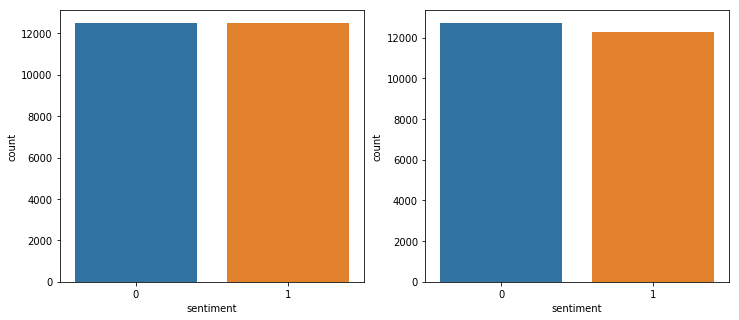

In [75]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

In [76]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

436


0    12718
1    12282
Name: sentiment, dtype: int64